   #                                    Neural Network from Scratch with NumPy

## Libraries

In [1]:

import numpy as np
from mnist import MNIST
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import unittest

## Dataset Loader

In [2]:

def load_mnist(mnist_path='MNIST'):
    mndata = MNIST(mnist_path)
    mndata.gz = False
    
    X_train, y_train = mndata.load_training()
    X_test, y_test = mndata.load_testing()

    X_train = np.array(X_train) / 255.0
    X_test = np.array(X_test) / 255.0
    
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    return X_train, X_test, y_train, y_test



## Neural Network Class

In [3]:
# --
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.params = {}
        self.grads = {}
        self._initialize_weights()

    def _initialize_weights(self):
        for i in range(1, len(self.layer_sizes)):
            self.params[f'W{i}'] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(2 / self.layer_sizes[i-1])
            self.params[f'b{i}'] = np.zeros((1, self.layer_sizes[i]))
            
    def _relu(self, Z):
        return np.maximum(0, Z)

    def _softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)

    def forward(self, X):
        self.cache = {}
        A = X
        self.cache['A0'] = X

        for i in range(1, len(self.layer_sizes) - 1):
            Z = np.dot(A, self.params[f'W{i}']) + self.params[f'b{i}']
            A = self._relu(Z)
            self.cache[f'Z{i}'] = Z
            self.cache[f'A{i}'] = A

        i = len(self.layer_sizes) - 1
        Z = np.dot(A, self.params[f'W{i}']) + self.params[f'b{i}']
        A = self._softmax(Z)
        self.cache[f'Z{i}'] = Z
        self.cache[f'A{i}'] = A

        return A

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, X, y_true):
        m = X.shape[0]
        num_layers = len(self.layer_sizes) - 1
        
        ###  Last layer
        dZ = self.cache[f'A{num_layers}'] - y_true
        self.grads[f'dW{num_layers}'] = np.dot(self.cache[f'A{num_layers-1}'].T, dZ) / m
        self.grads[f'db{num_layers}'] = np.sum(dZ, axis=0, keepdims=True) / m
        
        ### Hidden layers
        for i in range(num_layers - 1, 0, -1):
            dA = np.dot(dZ, self.params[f'W{i+1}'].T)
            dZ = dA * self._relu_derivative(self.cache[f'Z{i}'])
            self.grads[f'dW{i}'] = np.dot(self.cache[f'A{i-1}'].T, dZ) / m
            self.grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m

    def update_params(self):
        for i in range(1, len(self.layer_sizes)):
            self.params[f'W{i}'] -= self.learning_rate * self.grads[f'dW{i}']
            self.params[f'b{i}'] -= self.learning_rate * self.grads[f'db{i}']

    def train(self, X_train, y_train, epochs, batch_size=64, X_val=None, y_val=None, early_stopping_patience=None, early_stopping_threshold=1e-4):
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        m = X_train.shape[0]

        best_val_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(epochs):
            permutation = np.random.permutation(m)
            X_shuffled = X_train[permutation, :]
            y_shuffled = y_train[permutation, :]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size, :]
                y_batch = y_shuffled[i:i+batch_size, :]

                self.forward(X_batch)

                self.backward(X_batch, y_batch)

                self.update_params()

            y_pred_full = self.forward(X_train)
            loss = self.compute_loss(y_train, y_pred_full)
            predictions = self.predict(X_train)
            true_labels = np.argmax(y_train, axis=1)
            accuracy = np.mean(predictions == true_labels)

            history['loss'].append(loss)
            history['accuracy'].append(accuracy)

            if X_val is not None and y_val is not None:
                y_pred_val = self.forward(X_val)
                val_loss = self.compute_loss(y_val, y_pred_val)
                val_predictions = self.predict(X_val)
                val_true_labels = np.argmax(y_val, axis=1)
                val_accuracy = np.mean(val_predictions == val_true_labels)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_accuracy)
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

                if early_stopping_patience is not None:
                    if val_loss < best_val_loss - early_stopping_threshold:
                        best_val_loss = val_loss
                        epochs_without_improvement = 0
                    else:
                        epochs_without_improvement += 1
                    
                    if epochs_without_improvement >= early_stopping_patience:
                        print(f"Early stopping after {epoch + 1} epochs.")
                        break
            else:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        return history

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


## Model Training

In [4]:

def train_model_high_lr():
    
    X_train, X_test, y_train, y_test = load_mnist()

    split_index = int(0.9 * X_train.shape[0])
    X_train, X_val = X_train[:split_index], X_train[split_index:]
    y_train, y_val = y_train[:split_index], y_train[split_index:]

    ## Defining network architecture and hyperparameters
    layer_sizes = [X_train.shape[1], 128, 64, y_train.shape[1]]

    nn_high_lr = NeuralNetwork(layer_sizes, learning_rate=0.1)
    print("Training the neural network with learning rate 0.1...")
    history_high_lr = nn_high_lr.train(X_train, y_train, epochs=30, batch_size=64, X_val=X_val, y_val=y_val, early_stopping_patience=5)

    ## Evaluating the model
    print("Evaluating the neural network (lr=0.1)...")
    predictions_high_lr = nn_high_lr.predict(X_test)
    true_labels = np.argmax(y_test, axis=1)
    accuracy_high_lr = np.mean(predictions_high_lr == true_labels)
    print(f"Test accuracy (lr=0.1): {accuracy_high_lr:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_high_lr['loss'], label='Training Loss')
    plt.plot(history_high_lr['val_loss'], label='Validation Loss')
    plt.title('Loss (lr=0.1)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_high_lr['accuracy'], label='Training Accuracy')
    plt.plot(history_high_lr['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy (lr=0.1)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('training_history.png')
    plt.show()



## Model Testing

--- Running Training with Learning Rate 0.1 ---
Training the neural network with learning rate 0.1...
Epoch 1/30, Loss: 0.1833, Accuracy: 0.9463, Val Loss: 0.1556, Val Accuracy: 0.9560
Epoch 2/30, Loss: 0.1171, Accuracy: 0.9659, Val Loss: 0.1105, Val Accuracy: 0.9688
Epoch 3/30, Loss: 0.1038, Accuracy: 0.9697, Val Loss: 0.1122, Val Accuracy: 0.9663
Epoch 4/30, Loss: 0.0767, Accuracy: 0.9779, Val Loss: 0.0949, Val Accuracy: 0.9738
Epoch 5/30, Loss: 0.0525, Accuracy: 0.9849, Val Loss: 0.0772, Val Accuracy: 0.9780
Epoch 6/30, Loss: 0.0616, Accuracy: 0.9808, Val Loss: 0.0912, Val Accuracy: 0.9745
Epoch 7/30, Loss: 0.0400, Accuracy: 0.9885, Val Loss: 0.0802, Val Accuracy: 0.9763
Epoch 8/30, Loss: 0.0349, Accuracy: 0.9903, Val Loss: 0.0760, Val Accuracy: 0.9782
Epoch 9/30, Loss: 0.0431, Accuracy: 0.9858, Val Loss: 0.0893, Val Accuracy: 0.9750
Epoch 10/30, Loss: 0.0288, Accuracy: 0.9914, Val Loss: 0.0759, Val Accuracy: 0.9777
Epoch 11/30, Loss: 0.0208, Accuracy: 0.9947, Val Loss: 0.0694, Val 

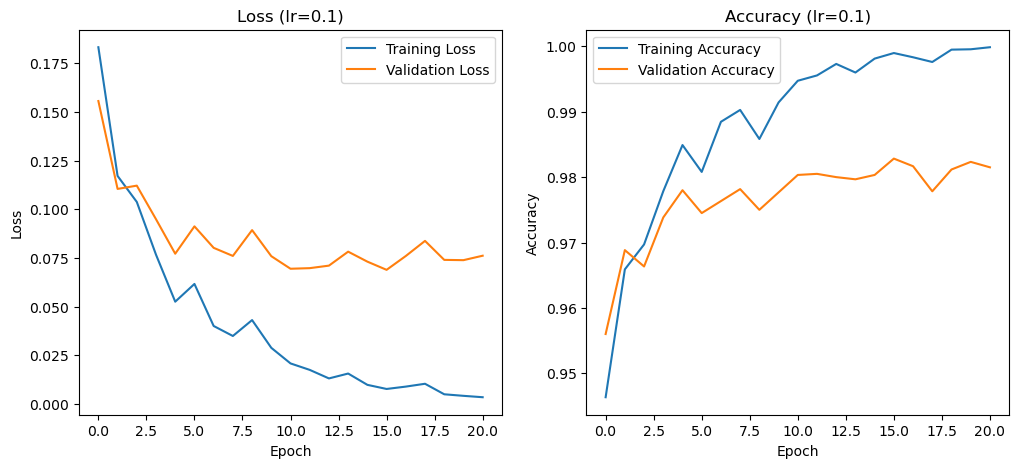

In [7]:

class TestNeuralNetwork(unittest.TestCase):
    def setUp(self):
        self.layer_sizes = [2, 3, 2]
        self.nn = NeuralNetwork(self.layer_sizes)
        self.X = np.array([[0.1, 0.2]])
        self.y = np.array([[1, 0]])

    def test_forward_pass(self):
        output = self.nn.forward(self.X)
        self.assertEqual(output.shape, (1, 2))
        self.assertAlmostEqual(np.sum(output), 1.0)

    def test_backward_pass(self):
        y_pred = self.nn.forward(self.X)
        self.nn.backward(self.X, self.y)
        analytical_grads = self.nn.grads

        epsilon = 1e-5
        numerical_grads = {}
        ## Create a temporary instance of NeuralNetwork for numerical gradient calculation
        ## to avoid modifying the original nn.params
        temp_nn = NeuralNetwork(self.layer_sizes)
        for key, param in self.nn.params.items():
            temp_nn.params[key] = np.copy(param) 

            numerical_grads[f'd{key}'] = np.zeros_like(param)
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    original_val = temp_nn.params[key][i, j]

                    temp_nn.params[key][i, j] = original_val + epsilon
                    y_pred_plus = temp_nn.forward(self.X)
                    loss_plus = temp_nn.compute_loss(self.y, y_pred_plus)

                    temp_nn.params[key][i, j] = original_val - epsilon
                    y_pred_minus = temp_nn.forward(self.X)
                    loss_minus = temp_nn.compute_loss(self.y, y_pred_minus)

                    numerical_grads[f'd{key}'][i, j] = (loss_plus - loss_minus) / (2 * epsilon)
                    temp_nn.params[key][i, j] = original_val

        for key in analytical_grads.keys():
            self.assertTrue(np.allclose(analytical_grads[key], numerical_grads[key], rtol=1e-5, atol=1e-5))


if __name__ == '__main__':
    print("--- Running Training with Learning Rate 0.1 ---")
    train_model_high_lr()
    
    